<a href="https://colab.research.google.com/github/ywchanna2001/Milk_Bottles-_Defects_Detection/blob/main/Milk_Bottel_Defect_Detection_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install the necessary libraries

In [8]:
!pip install ultralytics pandas matplotlib seaborn albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00


## Define Project Paths

In [2]:
import os

GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/Milk_Bottle_Defects_Detection"

# Path to the data.yaml file
DATA_YAML_PATH = os.path.join(GDRIVE_PROJECT_PATH, "Dataset_Original", "data.yaml")

# Path for all our training outputs
OUTPUT_PATH = os.path.join(GDRIVE_PROJECT_PATH, "Training_Outputs")

# Path to original Roboflow export folder (containing the single 'train' folder)
SOURCE_DATASET_DIR = "/content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Original"

# Path for the intermediate balanced (but unsplit) dataset
BALANCED_UNSPLIT_DIR = "/content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Balanced_Unsplit"

# Path for the final, split dataset that YOLO will use
FINAL_SPLIT_DIR = "/content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Final_Split"


# Create the output directory in Google Drive if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(BALANCED_UNSPLIT_DIR, exist_ok=True)
os.makedirs(FINAL_SPLIT_DIR, exist_ok=True)
print(f"Project Path: {GDRIVE_PROJECT_PATH}")
print(f"Output Path for models and results: {OUTPUT_PATH}")
print(f"Data yaml Path : {DATA_YAML_PATH}")
print(f"Source Dataset Path : {SOURCE_DATASET_DIR}")
print(f"Balanced Unsplit Dataset Path : {BALANCED_UNSPLIT_DIR}")
print(f"Final Split Dataset Path : {FINAL_SPLIT_DIR}")

Project Path: /content/drive/MyDrive/Milk_Bottle_Defects_Detection
Output Path for models and results: /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Training_Outputs
Data yaml Path : /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Original/data.yaml
Source Dataset Path : /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Original
Balanced Unsplit Dataset Path : /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Balanced_Unsplit
Final Split Dataset Path : /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Final_Split


## Calculate Initial Class Distribution

--- Initial Class Distribution ---
         Class Name  Object Count
4        MouthCrack           801
5         OtherLogo           429
2    LuckyLogoClear           414
1        ClearLabel           306
0         BodyCrack           210
3  LuckyLogoUnclear           207
6      UnclearLabel           159

--- Visualizing Class Distribution ---


/tmp/ipython-input-4254606124.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Class Name", y="Object Count", data=df, palette="viridis", orient='v')


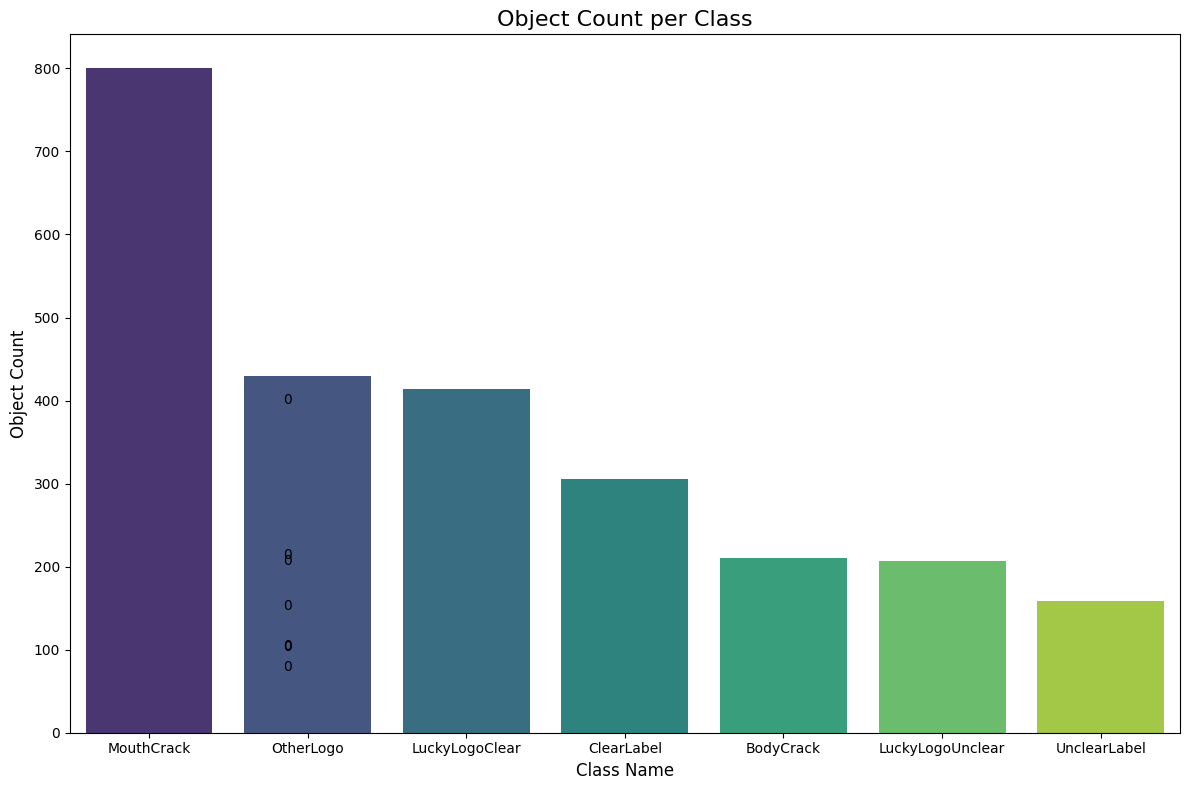

In [3]:
# Analyze and Visualize Class Distribution
import yaml
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load the data.yaml file to get class names
with open(DATA_YAML_PATH, 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']

# Path to image labels folder
labels_path = os.path.join(GDRIVE_PROJECT_PATH, "Dataset_Original/train/labels")

# Count occurrences of each class index
class_counts = Counter()
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        with open(os.path.join(labels_path, filename), 'r') as f:
            for line in f:
                class_index = int(line.split()[0])
                class_counts[class_index] += 1 # class_count[class_index] = class_count[class_index] + 1

# Create a human-readable report using pandas
# Ensure the DataFrame is sorted by Object Count for better visualization
report_data = {
    "Class Name": [class_names[i] for i in sorted(class_counts.keys())],
    "Object Count": [class_counts[i] for i in sorted(class_counts.keys())]
}
df = pd.DataFrame(report_data).sort_values(by="Object Count", ascending=False)

print("--- Initial Class Distribution ---")
print(df)

print("\n--- Visualizing Class Distribution ---")

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot using seaborn
ax = sns.barplot(x="Class Name", y="Object Count", data=df, palette="viridis", orient='v')

# Add titles and labels for clarity
plt.title("Object Count per Class", fontsize=16)
plt.ylabel("Object Count", fontsize=12)
plt.xlabel("Class Name", fontsize=12)

# Add the exact count on top of each bar for better readability
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'left', va = 'center',
                xytext = (5, 0),
                textcoords = 'offset points')

# Show the plot
plt.tight_layout()
plt.show()

## OFFLINE AUGMENTATION & DATASET BALANCING SCRIPT

In [5]:
import cv2
import yaml
import numpy as np
import albumentations as A
import random
import shutil
from collections import Counter
from tqdm import tqdm
import pandas as pd


# --- UTILITY FUNCTIONS  ---
def get_yolo_labels(label_path):
    """
    Reads a YOLO label file, performs robust sanitization, and returns a
    list of clean bounding boxes.
    """
    sanitized_labels = []
    if not os.path.exists(label_path):
        return sanitized_labels

    with open(label_path, 'r') as f:
        for line in f:
            try:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                class_id = int(parts[0])
                x_c, y_c, w, h = [float(p) for p in parts[1:]]

                # --- START OF ROBUST FIX ---
                # 1. Convert YOLO to min/max format
                x_min = x_c - w / 2
                y_min = y_c - h / 2
                x_max = x_c + w / 2
                y_max = y_c + h / 2

                # 2. Clip min/max values to be within [0.0, 1.0]
                x_min = np.clip(x_min, 0.0, 1.0)
                y_min = np.clip(y_min, 0.0, 1.0)
                x_max = np.clip(x_max, 0.0, 1.0)
                y_max = np.clip(y_max, 0.0, 1.0)

                # 3. Convert sanitized min/max back to YOLO
                new_w = x_max - x_min
                new_h = y_max - y_min
                new_x_c = x_min + new_w / 2
                new_y_c = y_min + new_h / 2

                # 4. Only add if the box still has a valid area
                if new_w > 1e-6 and new_h > 1e-6: # Check for a tiny positive area
                    sanitized_labels.append([class_id, new_x_c, new_y_c, new_w, new_h])
                # --- END OF ROBUST FIX ---

            except (ValueError, IndexError):
                print(f"Warning: Skipping malformed line in {label_path}: '{line.strip()}'")
                continue
    return sanitized_labels


def save_yolo_labels(label_path, labels):
    """Saves a list of bounding boxes to a YOLO format label file."""
    with open(label_path, 'w') as f:
        for label in labels:
            class_id = int(label[0])
            coords = ' '.join([f'{c:.6f}' for c in label[1:]])
            f.write(f'{class_id} {coords}\n')

# --- DEFINE AUGMENTATION PIPELINE ---
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.4, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Blur(blur_limit=4, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.1))

print("--- Starting Dataset Balancing Script ---")

# --- SETUP DIRECTORIES FOR BALANCED (UNSPLIT) DATA ---
if os.path.exists(BALANCED_UNSPLIT_DIR):
    shutil.rmtree(BALANCED_UNSPLIT_DIR)
os.makedirs(os.path.join(BALANCED_UNSPLIT_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(BALANCED_UNSPLIT_DIR, 'labels'), exist_ok=True)
print(f"Created new unsplit dataset directory structure at: {BALANCED_UNSPLIT_DIR}")

# --- LOAD CONFIG and ANALYZE DATASET ---
with open(DATA_YAML_PATH, 'r') as file:
    data_config = yaml.safe_load(file)
    class_names = data_config['names']

source_images_dir = os.path.join(SOURCE_DATASET_DIR, 'train/images')
source_labels_dir = os.path.join(SOURCE_DATASET_DIR, 'train/labels')

image_files = [f for f in os.listdir(source_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
class_instance_counts = Counter()
images_per_class = {i: [] for i in range(len(class_names))}

print("Analyzing source training data...")
for img_file in tqdm(image_files):
    label_file = os.path.splitext(img_file)[0] + '.txt'
    labels = get_yolo_labels(os.path.join(source_labels_dir, label_file))
    for label in labels:
        class_id = int(label[0])
        class_instance_counts[class_id] += 1
        if img_file not in images_per_class[class_id]:
            images_per_class[class_id].append(img_file)

# --- PERFORM BALANCING ---
print("\n--- Starting Balancing Process ---")
TARGET_INSTANCES = 800 # Set your target
dest_images_dir = os.path.join(BALANCED_UNSPLIT_DIR, 'images')
dest_labels_dir = os.path.join(BALANCED_UNSPLIT_DIR, 'labels')
final_class_counts = Counter()

# Step 1: Undersampling
print(f"Step 1: Undersampling classes with > {TARGET_INSTANCES} instances...")
images_to_process = sorted(image_files)
random.shuffle(images_to_process)
for img_file in tqdm(images_to_process, desc="Undersampling"):
    label_file = os.path.splitext(img_file)[0] + '.txt'
    labels = get_yolo_labels(os.path.join(source_labels_dir, label_file))
    can_add = all(final_class_counts[int(l[0])] < TARGET_INSTANCES for l in labels)
    if can_add:
        shutil.copy(os.path.join(source_images_dir, img_file), os.path.join(dest_images_dir, img_file))
        shutil.copy(os.path.join(source_labels_dir, label_file), os.path.join(dest_labels_dir, label_file))
        for label in labels:
            final_class_counts[int(label[0])] += 1

# Step 2: Oversampling with augmentation
print(f"\nStep 2: Oversampling classes with < {TARGET_INSTANCES} instances...")
for class_id in range(len(class_names)):
    if final_class_counts[class_id] < TARGET_INSTANCES:
        num_needed = TARGET_INSTANCES - final_class_counts[class_id]
        print(f"Augmenting class '{class_names[class_id]}'. Need {num_needed} more instances.")

        possible_images = images_per_class[class_id]
        if not possible_images:
            print(f"Warning: No source images found for class '{class_names[class_id]}'. Cannot augment.")
            continue

        pbar = tqdm(total=num_needed, desc=f"Augmenting {class_names[class_id]}")
        aug_count = 0
        while final_class_counts[class_id] < TARGET_INSTANCES:
            img_to_aug = random.choice(possible_images)
            img_path = os.path.join(source_images_dir, img_to_aug)
            label_path = os.path.join(source_labels_dir, os.path.splitext(img_to_aug)[0] + '.txt')

            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            labels = get_yolo_labels(label_path)
            if not labels:
                continue

            bboxes = [l[1:] for l in labels]
            class_labels = [l[0] for l in labels]

            try:
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            except ValueError as e:
                print(f"\nSkipping augmentation for {img_to_aug} due to error: {e}")
                continue

            if transformed['bboxes']:
                base_name = os.path.splitext(img_to_aug)[0]
                new_img_name = f"{base_name}_aug_{aug_count}.jpg"
                new_label_name = f"{base_name}_aug_{aug_count}.txt"

                aug_image = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(dest_images_dir, new_img_name), aug_image)

                new_labels = [[l] + list(b) for l, b in zip(transformed['class_labels'], transformed['bboxes'])]
                save_yolo_labels(os.path.join(dest_labels_dir, new_label_name), new_labels)

                initial_count = final_class_counts[class_id]
                for l in new_labels:
                    final_class_counts[int(l[0])] += 1

                instances_added = final_class_counts[class_id] - initial_count
                if instances_added > 0:
                  pbar.update(instances_added)
                aug_count += 1
        pbar.close()

print("\n--- Final Class Distribution (Post-Balancing) ---")
# (Code to print the final DataFrame report)

print(f"\n✅ Successfully created balanced but UNSPLIT dataset at: {BALANCED_UNSPLIT_DIR}")

/tmp/ipython-input-7195376.py:74: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=25, p=0.4, border_mode=cv2.BORDER_CONSTANT, value=0),


--- Starting Dataset Balancing Script ---
Created new unsplit dataset directory structure at: /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Balanced_Unsplit
Analyzing source training data...


100%|██████████| 2265/2265 [00:05<00:00, 397.62it/s]



--- Starting Balancing Process ---
Step 1: Undersampling classes with > 800 instances...


Undersampling: 100%|██████████| 2265/2265 [01:40<00:00, 22.64it/s]



Step 2: Oversampling classes with < 800 instances...
Augmenting class 'BodyCrack'. Need 590 more instances.


Augmenting BodyCrack: 591it [00:16, 35.87it/s]


Augmenting class 'ClearLabel'. Need 423 more instances.


Augmenting ClearLabel: 100%|██████████| 423/423 [00:16<00:00, 25.82it/s]


Augmenting class 'LuckyLogoClear'. Need 287 more instances.


Augmenting LuckyLogoClear: 100%|██████████| 287/287 [00:12<00:00, 23.79it/s]


Augmenting class 'LuckyLogoUnclear'. Need 555 more instances.


Augmenting LuckyLogoUnclear: 100%|██████████| 555/555 [00:21<00:00, 25.57it/s]


Augmenting class 'OtherLogo'. Need 282 more instances.


Augmenting OtherLogo: 100%|██████████| 282/282 [00:07<00:00, 39.05it/s]


Augmenting class 'UnclearLabel'. Need 619 more instances.


Augmenting UnclearLabel: 100%|██████████| 619/619 [00:24<00:00, 25.65it/s]


--- Final Class Distribution (Post-Balancing) ---

✅ Successfully created balanced but UNSPLIT dataset at: /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Balanced_Unsplit


## Calculate the class distribution after the class balancing

--- Class Distribution after balancing---
         Class Name  Object Count
0         BodyCrack           880
1    LuckyLogoClear           834
3        MouthCrack           801
2  LuckyLogoUnclear           800
4         OtherLogo           800

--- Visualizing Class Distribution ---


/tmp/ipython-input-2002930321.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Class Name", y="Object Count", data=df, palette="viridis", orient='v')


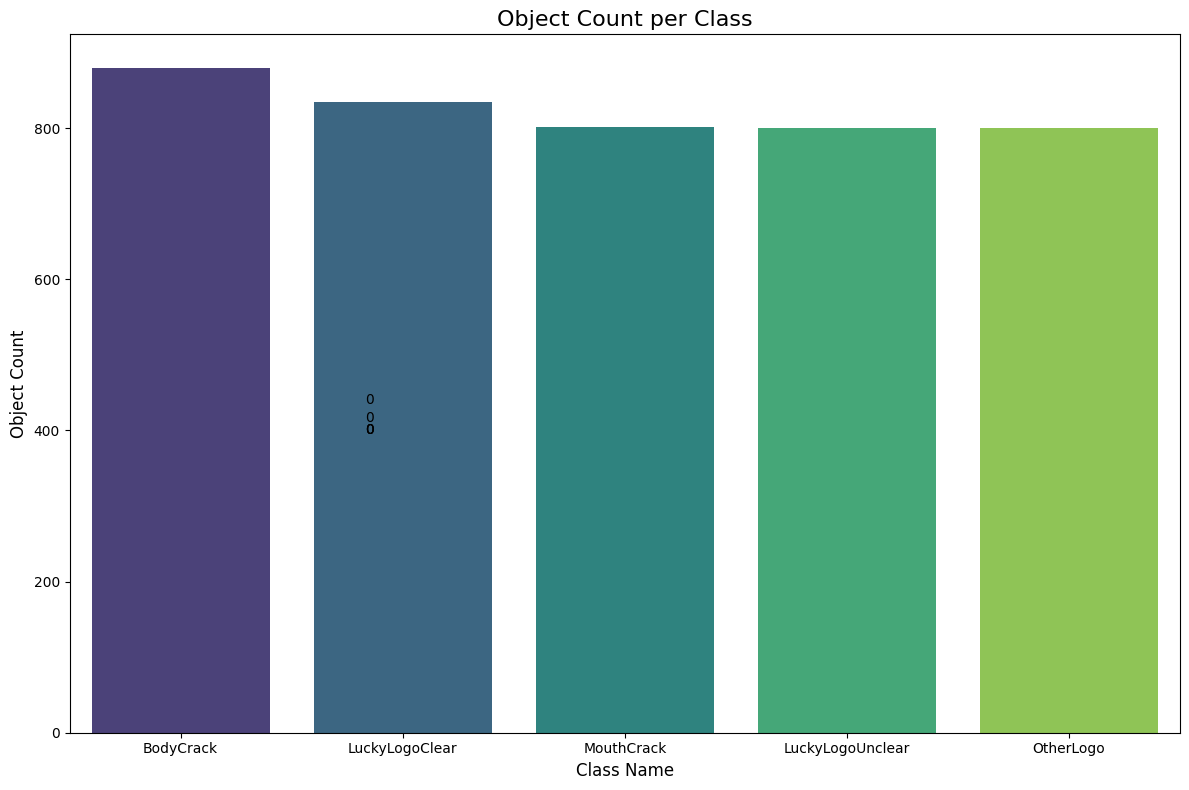

In [ ]:
# Load the data.yaml file to get class names
with open(DATA_YAML_PATH, 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']

# Path to image labels folder
labels_path = os.path.join(GDRIVE_PROJECT_PATH, "Dataset_Balanced_Unsplit/labels")

# Count occurrences of each class index
class_counts = Counter()
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        with open(os.path.join(labels_path, filename), 'r') as f:
            for line in f:
                class_index = int(line.split()[0])
                class_counts[class_index] += 1 # class_count[class_index] = class_count[class_index] + 1

# Create a human-readable report using pandas
# Ensure the DataFrame is sorted by Object Count for better visualization
report_data = {
    "Class Name": [class_names[i] for i in sorted(class_counts.keys())],
    "Object Count": [class_counts[i] for i in sorted(class_counts.keys())]
}
df = pd.DataFrame(report_data).sort_values(by="Object Count", ascending=False)

print("--- Class Distribution after balancing---")
print(df)

print("\n--- Visualizing Class Distribution ---")

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot using seaborn
ax = sns.barplot(x="Class Name", y="Object Count", data=df, palette="viridis", orient='v')

# Add titles and labels for clarity
plt.title("Object Count per Class", fontsize=16)
plt.ylabel("Object Count", fontsize=12)
plt.xlabel("Class Name", fontsize=12)

# Add the exact count on top of each bar for better readability
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'left', va = 'center',
                xytext = (5, 0),
                textcoords = 'offset points')

# Show the plot
plt.tight_layout()
plt.show()

### Splitting balanced dataset

In [6]:
print(f"--- Splitting the balanced dataset from {BALANCED_UNSPLIT_DIR} ---")

# Clean the final destination directory
if os.path.exists(FINAL_SPLIT_DIR):
    shutil.rmtree(FINAL_SPLIT_DIR)
    print(f"Removed existing final directory: {FINAL_SPLIT_DIR}")

# Create the final train/valid/test structure
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(FINAL_SPLIT_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(FINAL_SPLIT_DIR, split, 'labels'), exist_ok=True)

# Get all image filenames from the balanced directory
balanced_images_dir = os.path.join(BALANCED_UNSPLIT_DIR, 'images')
all_files = [os.path.splitext(f)[0] for f in os.listdir(balanced_images_dir)]
random.shuffle(all_files)

# Define split ratios
train_ratio = 0.7
valid_ratio = 0.15
# test_ratio is implicitly 0.15

# Calculate split indices
train_idx = int(len(all_files) * train_ratio)  # 4000 * 0.7 = 2800
valid_idx = int(len(all_files) * (train_ratio + valid_ratio)) # 4000 * (0.7+0.15) =

# Create file lists
train_files = all_files[:train_idx]
valid_files = all_files[train_idx:valid_idx]
test_files = all_files[valid_idx:]

# Function to copy files
def copy_files(file_list, dest_split_name):
    for filename in tqdm(file_list, desc=f"Copying to {dest_split_name}"):
        # Assuming .jpg, add logic for other extensions if needed
        shutil.copy(os.path.join(balanced_images_dir, filename + ".jpg"), os.path.join(FINAL_SPLIT_DIR, dest_split_name, 'images'))
        shutil.copy(os.path.join(BALANCED_UNSPLIT_DIR, 'labels', filename + ".txt"), os.path.join(FINAL_SPLIT_DIR, dest_split_name, 'labels'))

# Copy files to their final destinations
copy_files(train_files, 'train')
copy_files(valid_files, 'valid')
copy_files(test_files, 'test')

# --- Create the final data.yaml for the split dataset ---
final_yaml_path = os.path.join(FINAL_SPLIT_DIR, 'data.yaml')

# We use the original data_config to preserve class names and number
data_config['path'] = FINAL_SPLIT_DIR  # Root path for YOLO
data_config['train'] = 'train/images'
data_config['val'] = 'valid/images'
data_config['test'] = 'test/images'

with open(final_yaml_path, 'w') as file:
    yaml.dump(data_config, file, sort_keys=False)

print("\n--- Final Dataset Structure ---")
print(f"Training images: {len(os.listdir(os.path.join(FINAL_SPLIT_DIR, 'train/images')))}")
print(f"Validation images: {len(os.listdir(os.path.join(FINAL_SPLIT_DIR, 'valid/images')))}")
print(f"Test images: {len(os.listdir(os.path.join(FINAL_SPLIT_DIR, 'test/images')))}")
print(f"\n✅ Successfully created final, split dataset at: {FINAL_SPLIT_DIR}")
print(f"The new configuration file is at: {final_yaml_path}")

--- Splitting the balanced dataset from /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Balanced_Unsplit ---


Copying to test: 100%|██████████| 710/710 [00:16<00:00, 42.61it/s]



--- Final Dataset Structure ---
Training images: 3311
Validation images: 710
Test images: 710

✅ Successfully created final, split dataset at: /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Final_Split
The new configuration file is at: /content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Final_Split/data.yaml


In [ ]:
# Cell 7: Train the YOLOv8 model on the FINAL BALANCED & SPLIT dataset

# Define the path to the final data.yaml file
FINAL_DATA_YAML_PATH = os.path.join(FINAL_SPLIT_DIR, "data.yaml")

!yolo task=detect mode=train \
model=yolov8n.pt \
data="{FINAL_DATA_YAML_PATH}" \
epochs= 75 \
imgsz=640 \
project="{OUTPUT_PATH}" \
name="MilkBottle_Final_Run" \
exist_ok=True


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Milk_Bottle_Defects_Detection/Dataset_Final_Split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.